In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas import datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
'''
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
'''
plt.rc('font', family='NanumBarunGothic') 

# **기상청 기온 데이터 - ARIMA** 

In [38]:
data1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이터/기온,강수 클린 데이터/서울기온_편집.csv',
                    encoding = 'euc-kr')

In [39]:
data1

,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃)
0,\t2012-01-01,108.0,-3.0,-6.9,0.4
1,\t2012-01-02,108.0,-4.8,-8.3,-1.2
2,\t2012-01-03,108.0,-4.5,-6.8,-0.2
3,\t2012-01-04,108.0,-7.4,-9.6,-4.3
4,\t2012-01-05,108.0,-5.7,-9.8,-1.3
...,...,...,...,...,...
3953,\t2022-10-28,108.0,13.6,8.2,20.6
3954,\t2022-10-29,108.0,14.8,10.2,21.3
3955,\t2022-10-30,108.0,14.9,10.4,21.3
3956,\t2022-10-31,108.0,14.9,11.2,21.1


In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3958 entries, 0 to 3957
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   날짜       3958 non-null   object 
 1   지점       3957 non-null   float64
 2   평균기온(℃)  3957 non-null   float64
 3   최저기온(℃)  3956 non-null   float64
 4   최고기온(℃)  3956 non-null   float64
dtypes: float64(4), object(1)
memory usage: 154.7+ KB


In [40]:
data1 = data1.dropna()

In [41]:
#데이터 기본 전처리
data1 = data1.dropna()

date = []
string = data1['날짜']
for i in range(data1.shape[0]) :
    s = str(string.iloc[i,])
    a = re.sub(r'\t', '', s)
    a = pd.to_datetime(a)
    date.append(a)

data1['날짜'] = date
data1 = data1[['날짜', '평균기온(℃)']]
data1.rename(columns = {'날짜' : 'date', '평균기온(℃)':'avg_temp'}, inplace = True)

In [ ]:
train = data1.loc[data1.date <= '2021-12-31',:]
test = data1.loc[data1.date > '2021-12-31',:]
print(train.shape, test.shape)

(304, 2)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50872 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50669 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_

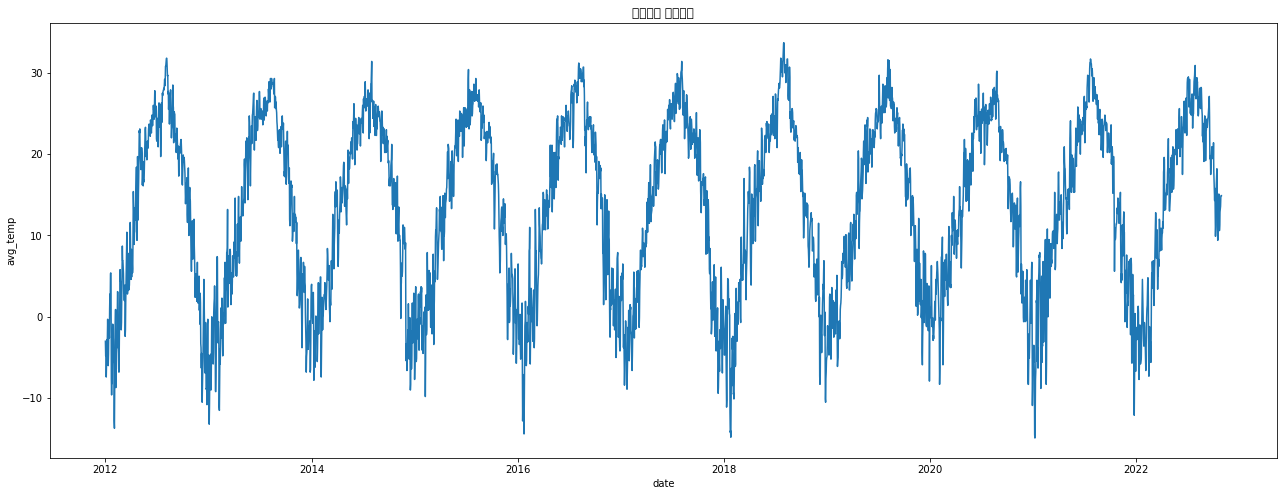

In [ ]:
#시계열 그래프
plt.figure(figsize=(22,8))
plt.plot(data1['date'], data1['avg_temp'])
plt.title('서울지역 평균기온')
plt.xlabel('date')
plt.ylabel('avg_temp')
plt.show()

In [45]:
#시계열 분해법
ts = data1.loc[:,['date', 'avg_temp']]
ts.index = ts['date']
ts = ts.drop('date', axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


<Figure size 432x288 with 0 Axes>

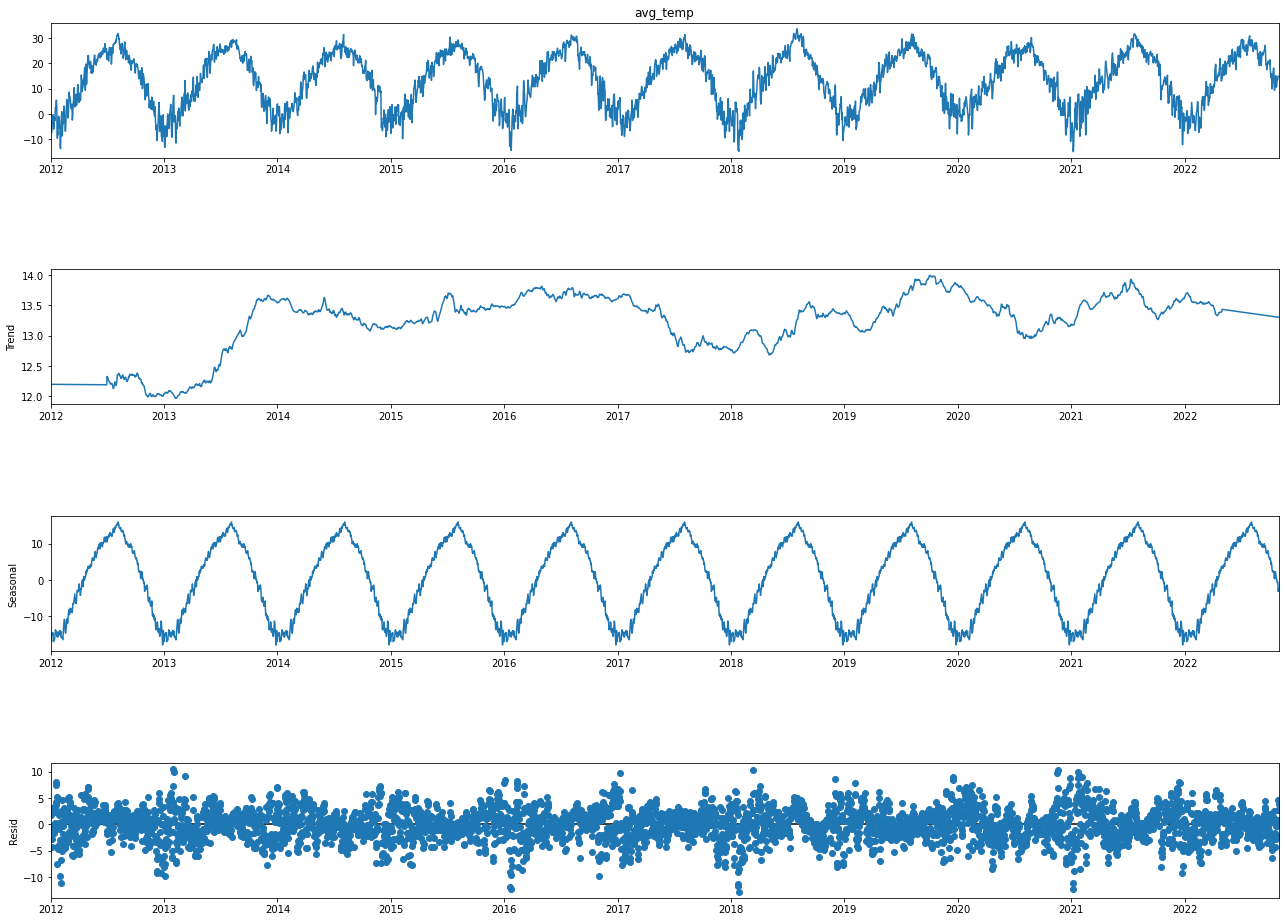

In [ ]:
result = seasonal_decompose(ts['avg_temp'], model = 'additive', freq = 365, extrapolate_trend=365)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,15)

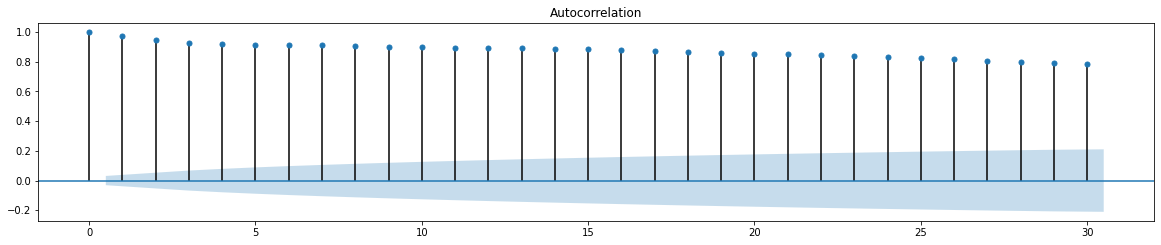

In [46]:
#차분 전 ACF 그래프
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags = 30, ax = ax1)

In [ ]:
res = seasonal_decompose(ts['avg_temp'], model = 'additive', freq = 365)
residual = res.resid
seasonal = res.seasonal
trend = res.trend
residual = residual.dropna()
print(residual)

date
2012-07-01   -1.417901
2012-07-02    0.767468
2012-07-03   -0.833326
2012-07-04    0.406455
2012-07-05   -0.875984
                ...   
2022-04-27    2.066784
2022-04-28    2.776044
2022-04-29   -2.898860
2022-04-30   -3.497956
2022-05-01   -3.108778
Name: resid, Length: 3591, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


In [104]:
#단위근 검정
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(residual)

NameError: ignored

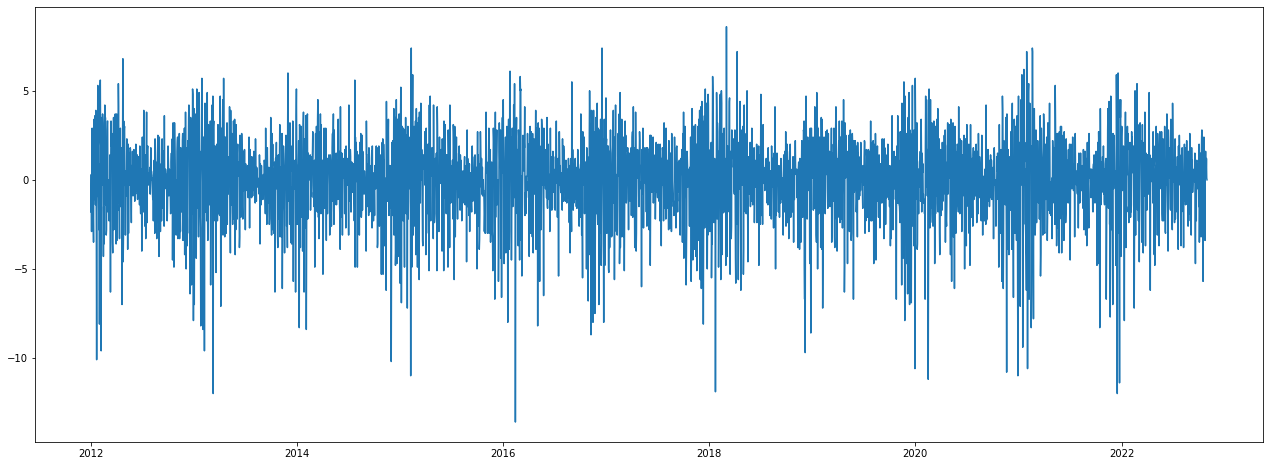

In [47]:
#계절성 제거
ts_diff = ts.diff(12)
plt.figure(figsize=(22,8))
plt.plot(ts_diff)
plt.show()

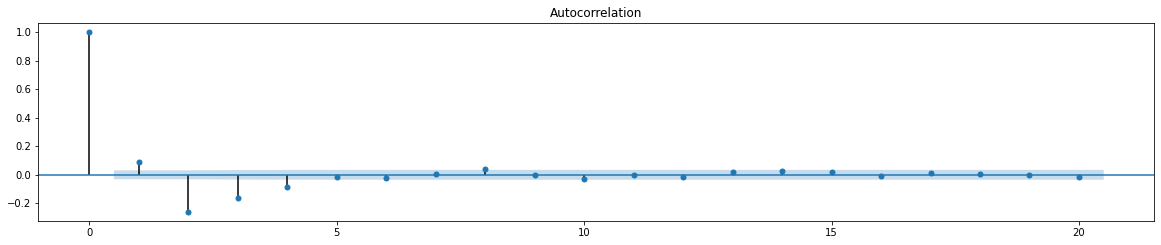

In [ ]:
#계절성 제거 후 ACF 그래프
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff[1:], lags = 20, ax = ax1)

#PACF 그래프
fig = plt.figure(figsize = (20,8))
ax2 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(ts_diff[1:], lags = 20, ax = ax2)

In [50]:
model = ARIMA(ts_diff, order = (2,1,2))
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.'

In [51]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               avg_temp   No. Observations:                 3955
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -8735.864
Date:                Thu, 10 Nov 2022   AIC                          17481.727
Time:                        12:06:02   BIC                          17513.139
Sample:                             0   HQIC                         17492.869
                               - 3955                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8843      0.015     59.168      0.000       0.855       0.914
ar.L2         -0.2850      0.014    -20.313      0.000      -0.313      -0.258
ma.L1         -1.8970      0.009   -208.398      0.0

In [52]:
prediction1 = model_fit.forecast(365)
pred1_date = pd.date_range('2022-10-29', periods=365, freq='D')
pred1_date = pd.DataFrame(pred1_date)
prediction1 = pd.DataFrame(prediction1).reset_index(drop=True)
prediction1 = pd.concat([pred1_date, prediction1['predicted_mean']], axis = 1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


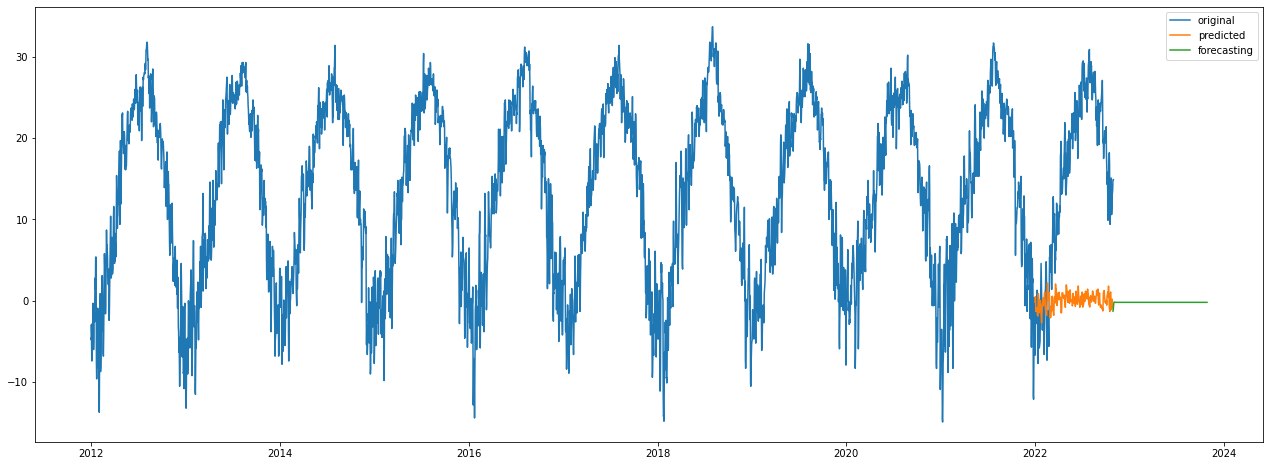

In [56]:
start_index = datetime(2022, 1, 1)
end_index = datetime(2022, 10, 28)

forecast = model_fit.predict(start = start_index, end=end_index, typ='levels')

plt.figure(figsize = (22,8))
plt.plot(data1['date'], data1['avg_temp'], label = 'original')
plt.plot(forecast, label = 'predicted')
plt.plot(prediction1[0], prediction1['predicted_mean'], label = 'forecasting')

plt.legend()
plt.show()

# **Holt-Winters**

In [67]:
exp_fit = ExponentialSmoothing(data1['avg_temp'], trend = 'add',
                               seasonal = 'add', seasonal_periods = ).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [68]:
print(exp_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 avg_temp   No. Observations:                 3955
Model:             ExponentialSmoothing   SSE                          20165.656
Optimized:                         True   AIC                           7180.696
Trend:                         Additive   BIC                           9499.026
Seasonal:                      Additive   AICC                          7257.733
Seasonal Periods:                   365   Date:                 Thu, 10 Nov 2022
Box-Cox:                          False   Time:                         12:08:52
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9999433                alpha                 True
smoothing_trend       

In [69]:
prediction2 = exp_fit.forecast(365)

pred2_date = pd.date_range('2022-10-29', periods=365, freq='D')
pred2_date = pd.DataFrame(pred2_date)

prediction2 = pd.DataFrame(prediction2).reset_index(drop=True)

prediction2.rename(columns = {0:'avg_temp'}, inplace = True)

prediction2 = pd.concat([pred2_date, prediction2['avg_temp']], axis = 1)

prediction2.rename(columns = {0:'date'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
prediction2

,date,avg_temp
0,2022-10-29,15.911075
1,2022-10-30,15.227801
2,2022-10-31,14.943863
3,2022-11-01,14.951385
4,2022-11-02,15.019197
...,...,...
360,2023-10-24,16.742703
361,2023-10-25,16.963320
362,2023-10-26,16.228194
363,2023-10-27,14.381460


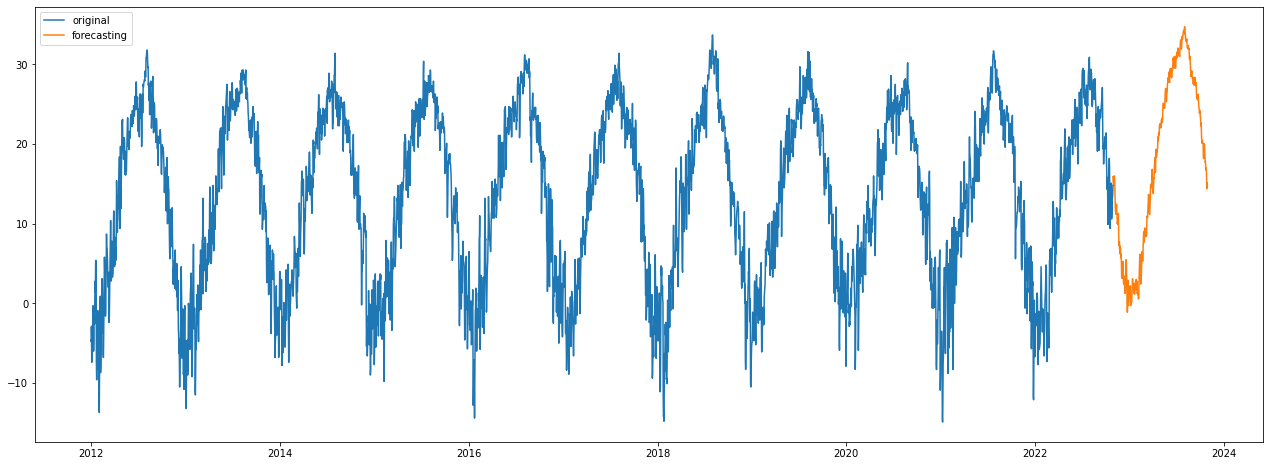

In [75]:
'''
start_index = datetime(2022, 1, 1)
end_index = datetime(2022, 10, 28)

forecast2 = exp_fit.predict(start = start_index, end=end_index, typ='levels')
'''

plt.figure(figsize = (22,8))
plt.plot(data1['date'], data1['avg_temp'], label = 'original')
#plt.plot(forecast2, label = 'predicted')
plt.plot(prediction2['date'], prediction2['avg_temp'], label = 'forecasting')

plt.legend()
plt.show()

-------------------------------------------------

# **Rain**

In [2]:
data2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이터/기온,강수 클린 데이터/강원영서강수량_편집.csv',
                    encoding = 'euc-kr')

In [3]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3957 entries, 0 to 3956
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   날짜       3957 non-null   object 
 1   지점       3957 non-null   object 
 2   강수량(mm)  3957 non-null   float64
dtypes: float64(1), object(2)
memory usage: 92.9+ KB


In [20]:
data2

,date,total_rain
0,2012-01-01,0.1
1,2012-01-02,0.0
2,2012-01-03,0.2
3,2012-01-04,0.0
4,2012-01-05,0.0
...,...,...
3952,2022-10-27,0.0
3953,2022-10-28,0.6
3954,2022-10-29,0.0
3955,2022-10-30,0.0


In [3]:
data2['날짜'] = pd.to_datetime(data2['날짜'])
data2 = data2.drop(['지점'], axis = 1)
data2 = data2.dropna()
data2.rename(columns = {'날짜' : 'date', '강수량(mm)':'total_rain'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50896 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50669 missing from current font.
  font.set_

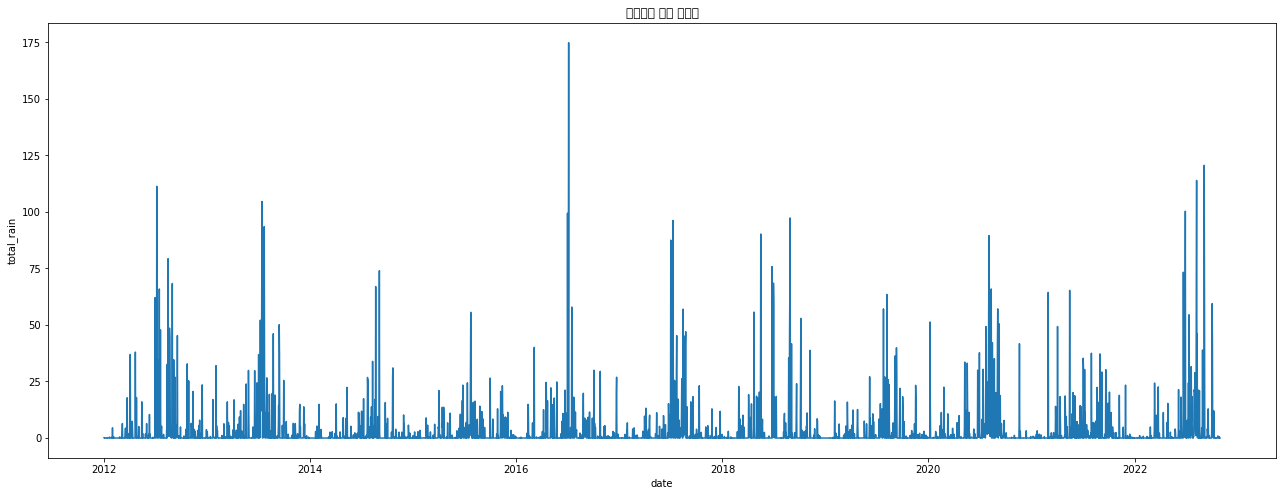

In [4]:
#시계열 그래프
plt.figure(figsize=(22,8))
plt.plot(data2['date'], data2['total_rain'])
plt.title('강원영서 지역 총강수')
plt.xlabel('date')
plt.ylabel('total_rain')
plt.show()

조건부 이분산성 확인
-> 강수가 많이 온 날의 주위의 날들의 경우에는 강수의 분산이 큰 형태를 발견

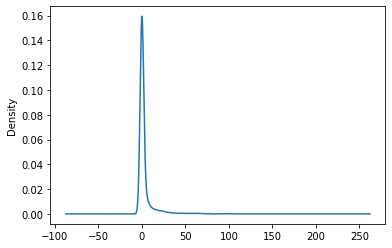

In [9]:
#kde plot 확인
data2['total_rain'].plot.kde()
plt.show()

In [5]:
#시계열 분해법
ts2 = data2.loc[:,['date', 'total_rain']]
ts2.index = ts2['date']
ts2 = ts2.drop('date', axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


<Figure size 432x288 with 0 Axes>

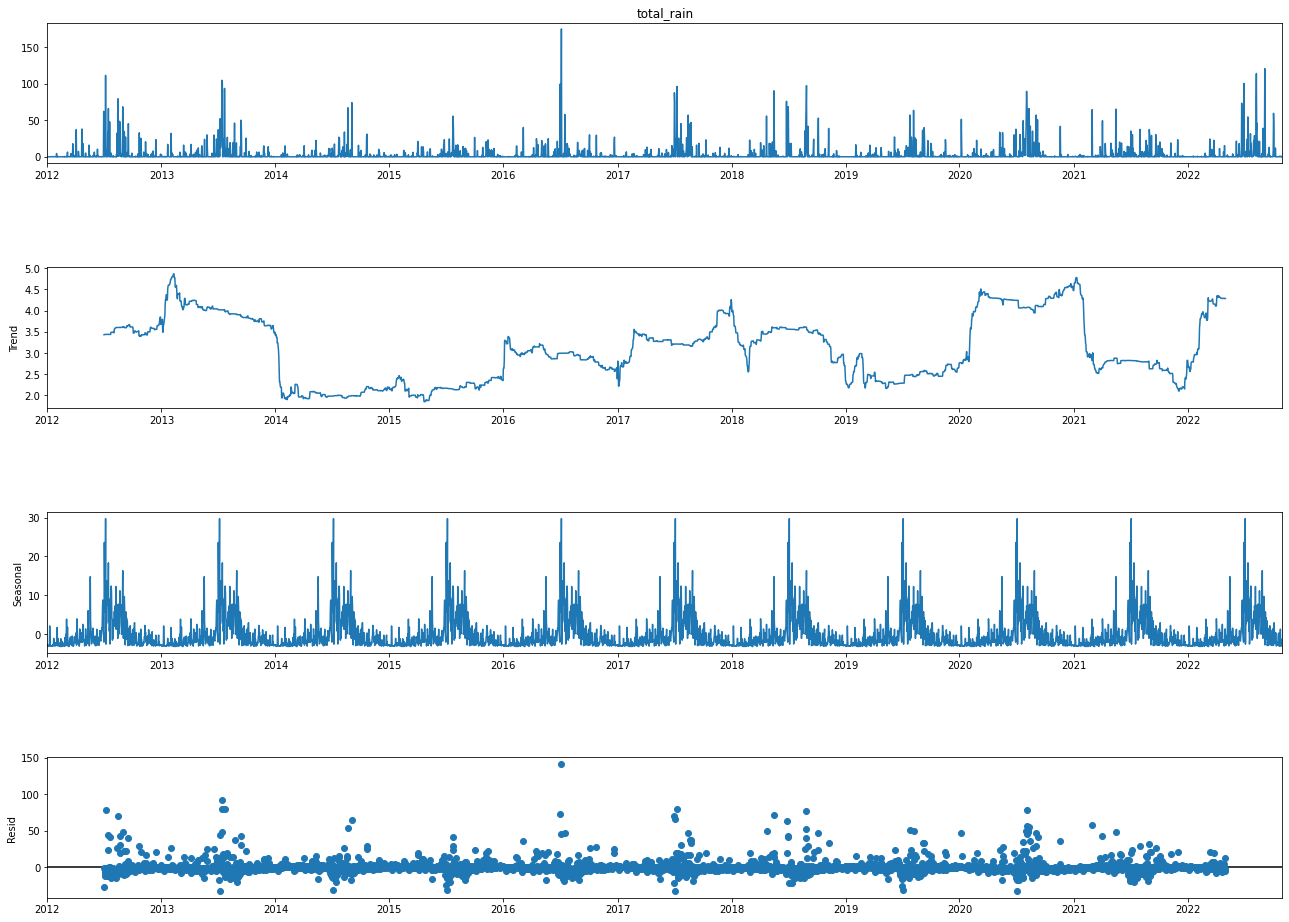

In [6]:
result2 = seasonal_decompose(ts2['total_rain'], model = 'additive', freq = 365)

fig = plt.figure()
fig = result2.plot()
fig.set_size_inches(20,15)

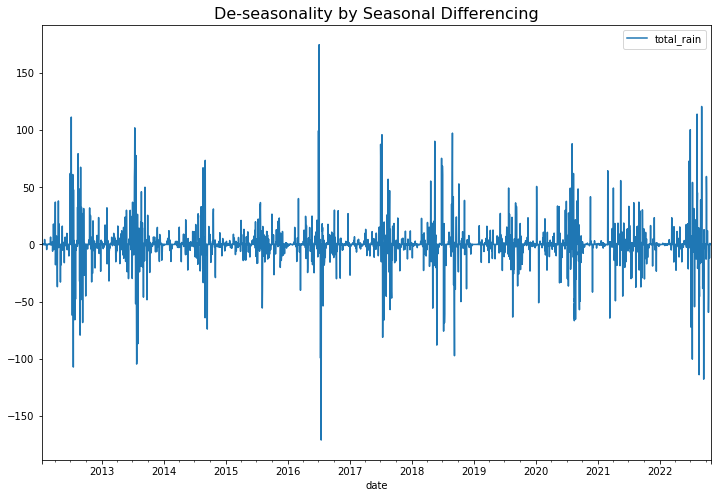

In [81]:
# 계절성 제거
data2_sea_diff = ts2.diff(12).dropna()

# plotting
data2_sea_diff.plot(figsize=(12, 8))
plt.title("De-seasonality by Seasonal Differencing", 
          fontsize=16)
plt.show()

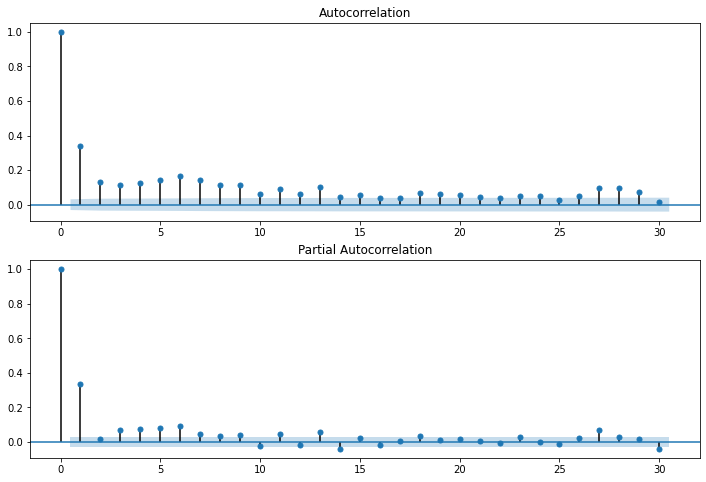

In [7]:
# Plot autocorrelation and partial autocorrelation of residuals
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts2, ax=ax1,lags=30)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts2, ax=ax2, method= 'ywmle',lags=30)

In [85]:
#adf 검정
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(data2_sea_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.840392e+01
p-value                        2.189987e-30
#Lags Used                     2.400000e+01
Number of Observations Used    3.920000e+03
Critical Value (1%)           -3.432019e+00
Critical Value (5%)           -2.862278e+00
Critical Value (10%)          -2.567163e+00
dtype: float64


In [87]:
#kpss test
def kpss_test(df) :
  statistic, p_value, n_lags, critical_values = kpss(df.values)
  print(f'KPSS Statistic: {statistic}')
  print(f'p_value: {p_value}')
  print(f'num_lags: {n_lags}')
  print(f'Critical Values:')
  for key, value in critical_values.items() :
    print(f' {key} : {value}')

In [89]:
kpss_test(data2_sea_diff) #정상성 만족

KPSS Statistic: 0.006919001564254831
p_value: 0.1
num_lags: 31
Critical Values:
 10% : 0.347
 5% : 0.463
 2.5% : 0.574
 1% : 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


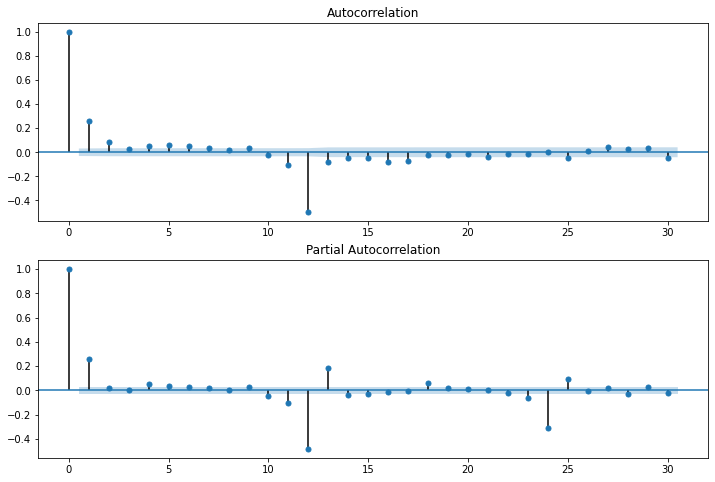

In [91]:
# 계절성 제거 후 plot
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data2_sea_diff, ax=ax1,lags=30)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data2_sea_diff, ax=ax2, method= 'ywmle',lags=30)

In [93]:
#AR모델
ar_model = ARIMA(data2_sea_diff, order = (2,0,0))
ar_res = ar_model.fit()
print(ar_res.aic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


32067.53635161157


In [94]:
#MA모델
ma_model = ARIMA(data2_sea_diff, order = (0,0,2))
ma_res = ar_model.fit()
print(ma_res.aic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


32067.53635161157


In [95]:
#ARMA 모델
arma_model = ARIMA(data2_sea_diff, order = (2,0,2))
arma_res = arma_model.fit()
print(arma_res.aic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


32066.669385506044


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(data2_sea_diff, boxpierce = True)
#2nd array : ljung box test
#4th array : box-pirece test -> 둘다 0.01 안 넘음 -> 자기상관성 존재 O

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:533: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([261.58582781, 273.02525991, 281.831843  , 307.45184242,
        344.47403781, 367.33962516, 385.18241847, 391.85070504,
        396.48358434, 398.0490411 , 400.82373638, 401.08513149,
        408.28223164, 410.80927343, 410.81273305, 411.10748056,
        413.94432431, 414.06069828, 415.47888197, 415.91596774,
        419.32626162, 421.60237804, 421.71373075, 421.9982501 ,
        425.94821359, 426.36705633, 426.37253215, 427.15200807,
        427.17834039, 432.18701945, 433.58861038, 433.58863276,
        433.6306375 , 435.82452771, 437.68626989, 438.9074473 ,
        439.53963794, 439.57502442, 439.61077315, 449.37033577]),
 array([7.74189923e-59, 5.16794759e-60, 8.50082005e-61, 2.67450719e-65,
        2.70859068e-72, 2.91734950e-76, 3.58393566e-79, 1.03630570e-79,
        7.70759640e-80, 2.44870367e-79, 4.09112296e-79, 2.22962054e-78,
        3.97960072e-79, 6.68403639e-79, 3.68893166e-78, 1.70672287e-77,
        2.24505064e-77, 1.06571551e-76, 2.63182417e-76, 1.01421261e-75

In [18]:
prediction4 = arma_model_fit.forecast(365)

In [21]:
pred4_date = pd.date_range('2022-10-31', periods=365, freq='D')
pred4_date = pd.DataFrame(pred4_date)

prediction4 = pd.DataFrame(prediction4).reset_index(drop=True)

prediction4 = pd.concat([pred4_date, prediction4['predicted_mean']], axis = 1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


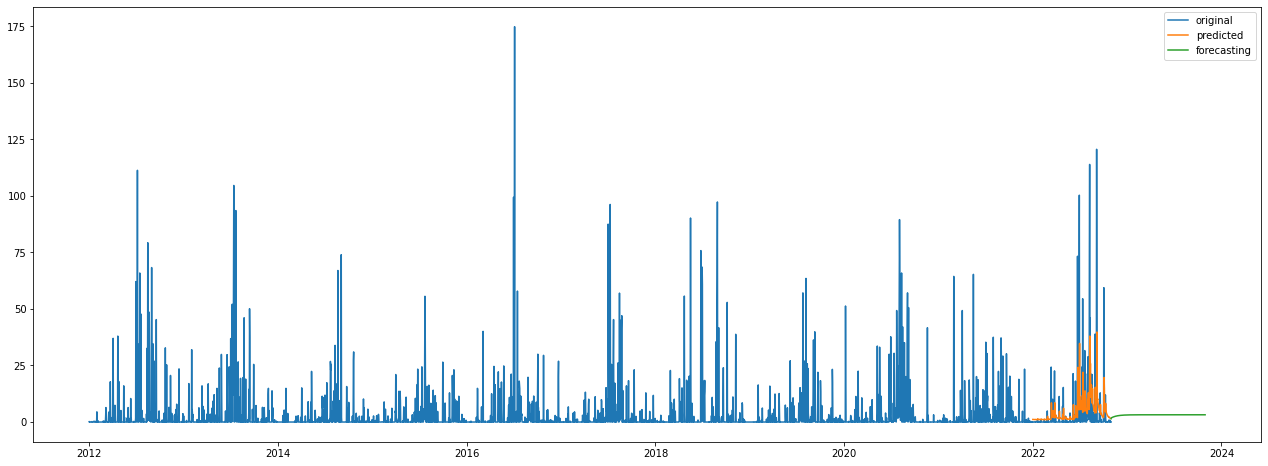

In [24]:
start_index = datetime(2022, 1, 1)
end_index = datetime(2022, 10, 28)

forecast4 = arma_model_fit.predict(start = start_index, end=end_index, typ='levels')

plt.figure(figsize = (22,8))
plt.plot(data2['date'], data2['total_rain'], label = 'original')
plt.plot(forecast4, label = 'predicted')
plt.plot(prediction4[0], prediction4['predicted_mean'], label = 'forecasting')

plt.legend()
plt.show()

In [98]:
from pmdarima import auto_arima

In [ ]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

In [102]:
modelaaa = auto_arima(data2_sea_diff, seasonal = False)

In [103]:
modelaaa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3945
Model:               SARIMAX(1, 0, 2)   Log Likelihood              -16027.677
Date:                Thu, 10 Nov 2022   AIC                          32063.353
Time:                        12:26:30   BIC                          32088.474
Sample:                    01-13-2012   HQIC                         32072.264
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6789      0.062     10.878      0.000       0.557       0.801
ma.L1         -0.4298      0.063     -6.851      0.000      -0.553      -0.307
ma.L2         -0.0966      0.024     -4.101      0.000      -0.143      -0.050
sigma2       197.8811      1.262    156.837      0.000     195.408     200.354
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            112422.74
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.03
Prob(H) (two-sided):                  0.03   Kurtosis:                        29.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
sarima = auto_arima(data2['total_rain'])
#m = 주기

In [35]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3957
Model:               SARIMAX(1, 0, 2)   Log Likelihood              -14671.706
Date:                Thu, 10 Nov 2022   AIC                          29353.411
Time:                        08:45:58   BIC                          29384.828
Sample:                             0   HQIC                         29364.554
                               - 3957                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1451      0.054      2.698      0.007       0.040       0.251
ar.L1          0.9546      0.009    109.827      0.000       0.938       0.972
ma.L1         -0.6500      0.010    -65.659      0.000      -0.669      -0.631
ma.L2         -0.2130      0.011    -20.088      0.000      -0.234      -0.192
sigma2        97.2825      0.727    133.758      0.000      95.857      98.708
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            331765.87
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             5.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **Holt winters**

In [10]:
exp_fit2 = ExponentialSmoothing(data2['total_rain'], trend = 'add',
                               seasonal = 'add', seasonal_periods = 365).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [11]:
print(exp_fit2.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               total_rain   No. Observations:                 3957
Model:             ExponentialSmoothing   SSE                         447262.595
Optimized:                         True   AIC                          19445.350
Trend:                         Additive   BIC                          21763.866
Seasonal:                      Additive   AICC                         19522.344
Seasonal Periods:                   365   Date:                 Thu, 10 Nov 2022
Box-Cox:                          False   Time:                         11:21:25
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.2043529                alpha                 True
smoothing_trend       

In [12]:
prediction3 = exp_fit2.forecast(365)

In [14]:
pred3_date = pd.date_range('2022-10-31', periods=365, freq='D')
pred3_date = pd.DataFrame(pred3_date)

In [15]:
prediction3 = pd.DataFrame(prediction3).reset_index(drop=True)

In [16]:
prediction3.rename(columns = {0:'total_rain'}, inplace = True)

In [17]:
prediction3 = pd.concat([pred3_date, prediction3['total_rain']], axis = 1)

In [18]:
prediction3.rename(columns = {0:'date'}, inplace = True)

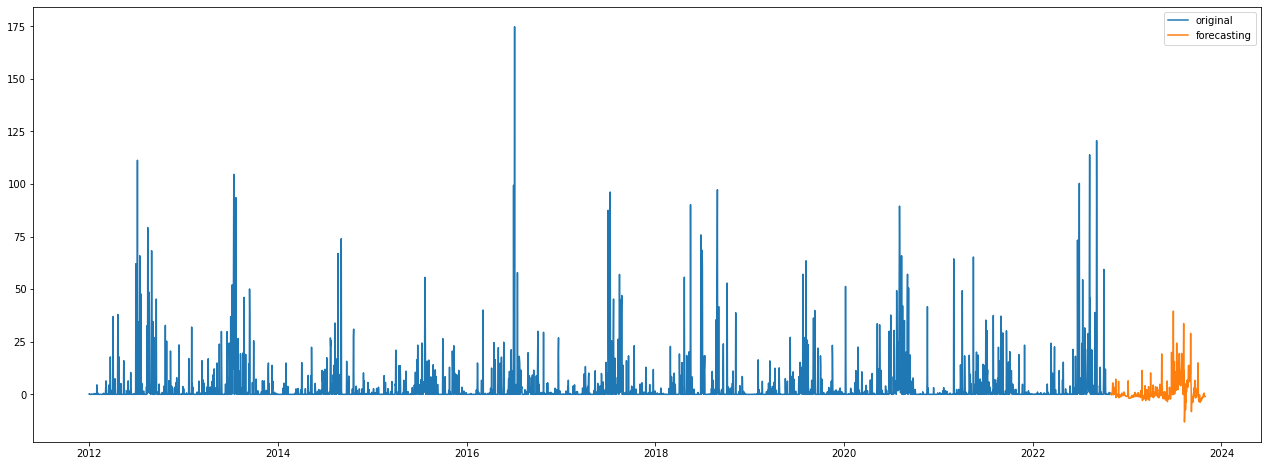

In [20]:
'''
start_index = datetime(2022, 1, 1)
end_index = datetime(2022, 10, 28)

forecast2 = exp_fit.predict(start = start_index, end=end_index, typ='levels')
'''

plt.figure(figsize = (22,8))
plt.plot(data2['date'], data2['total_rain'], label = 'original')
#plt.plot(forecast2, label = 'predicted')
plt.plot(prediction3['date'], prediction3['total_rain'], label = 'forecasting')

plt.legend()
plt.show()

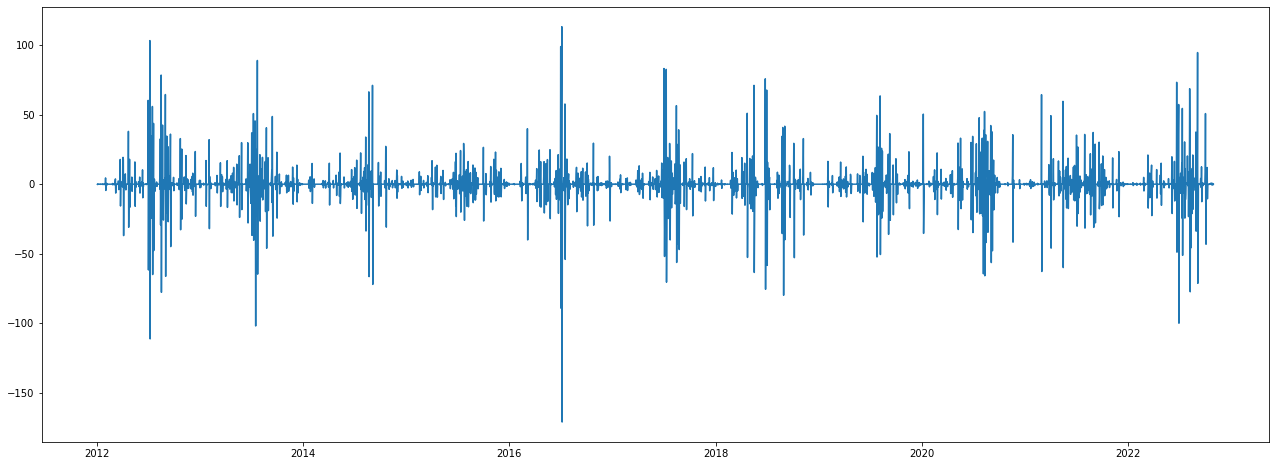

In [21]:
ts2_diff = ts2 - ts2.shift()
plt.figure(figsize=(22,8))
plt.plot(ts2_diff)
plt.show()

### **GARCH**

In [28]:
#pip install arch
import arch

In [29]:
from arch import arch_model

In [ ]:
data2

,date,total_rain
0,2012-01-01,0.1
1,2012-01-02,0.0
2,2012-01-03,0.2
3,2012-01-04,0.0
4,2012-01-05,0.0
...,...,...
3952,2022-10-27,0.0
3953,2022-10-28,0.6
3954,2022-10-29,0.0
3955,2022-10-30,0.0


In [ ]:
garch = arch_model(data_sea_diff)

In [35]:
ts2_diff = ts2_diff.dropna()

In [36]:
garch_model = arch_model(ts2_diff['total_rain'], vol='garch', p = 1, q = 1)

In [37]:
garch_model_fit = garch_model.fit(update_freq = 10)
print(garch_model_fit.summary())

Iteration:     10,   Func. Count:     56,   Neg. LLF: 14003.256702087067
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14003.256703755935
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             total_rain   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14003.3
Distribution:                  Normal   AIC:                           28014.5
Method:            Maximum Likelihood   BIC:                           28039.6
                                        No. Observations:                 3956
Date:                Thu, Nov 10 2022   Df Residuals:                     3955
Time:                        12:04:04   Df Model:                            1
      